# Correlation analyses

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from tqdm.auto import tqdm
import sys
import os
import glob
import seaborn as sns
from scipy.stats import iqr

## Define paths in directory

In [3]:
scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
study_sites_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/'
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

## Load snowlines, glacier boundaries, and ERA data

In [8]:
# -----Load snowlines
snowlines_path = os.path.join(scm_path, 'all_snowlines')
snowlines_fn = 'all_snowlines.csv'
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
snowlines.index = snowlines['datetime']
print('All snowlines loaded from file.')

# -----Load glacier boundaries
aois_path = os.path.join(scm_path, 'all_AOIs')
aois_fn = 'all_aois.shp'
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)
print('All glacier boundaries loaded from file.')

# -----Load ERA data 
eras_path = os.path.join(scm_path, 'all_ERA_data')
eras_fn = 'all_era_data.csv'
eras = pd.read_csv(os.path.join(eras_path, eras_fn))    
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')
print('All ERA data loaded from file.')


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_4951/3301756066.py:4: DtypeWarning: Columns (13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))


All snowlines loaded from file.
All glacier boundaries loaded from file.
All ERA data loaded from file.


## Calculate coefficients for AAR time series within subregions

Alaska Range


  0%|          | 0/32 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_AlaskaRange.csv


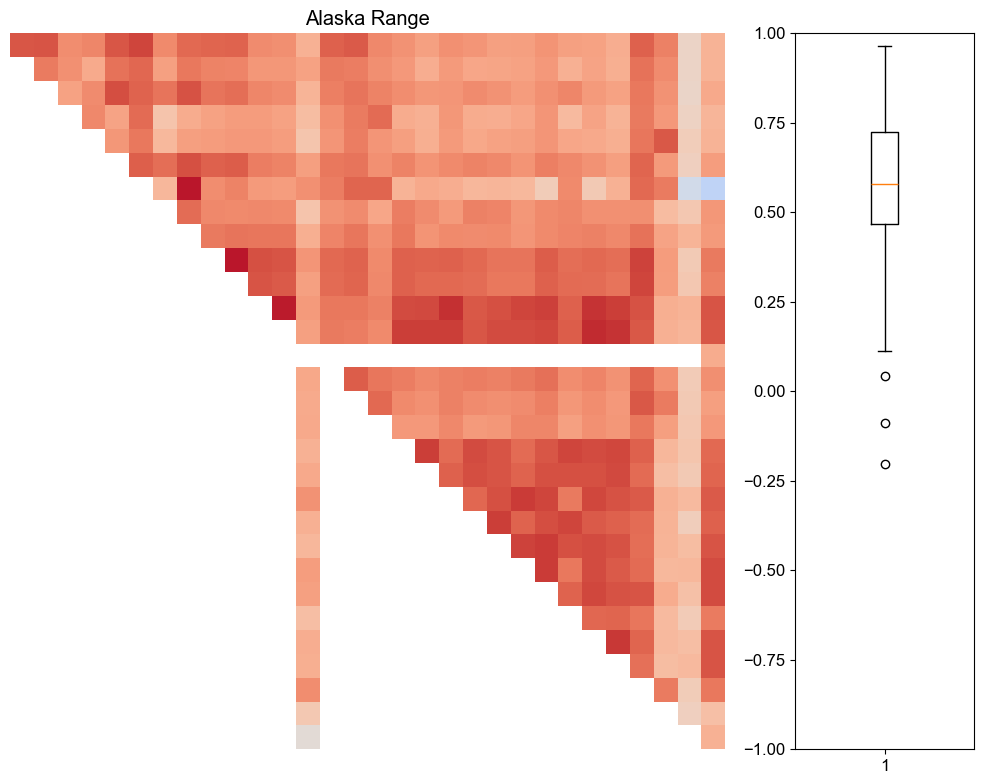

N. Coast Ranges


  0%|          | 0/26 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_NCoastRanges.csv


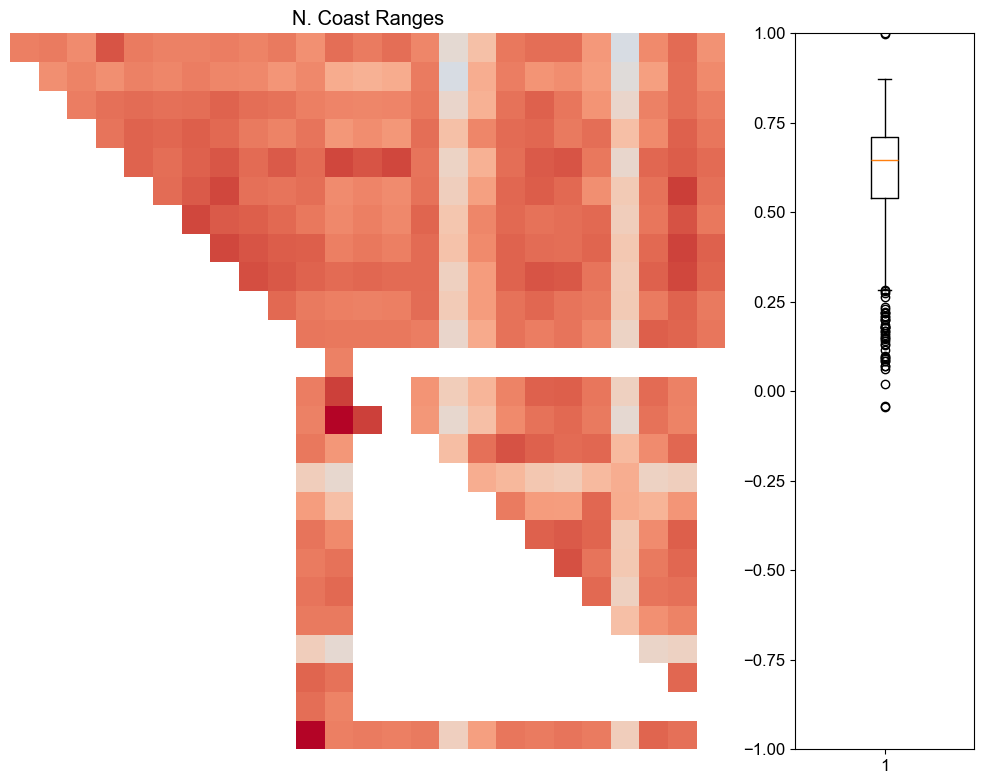

W. Chugach Mtns.


  0%|          | 0/20 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_WChugachMtns.csv


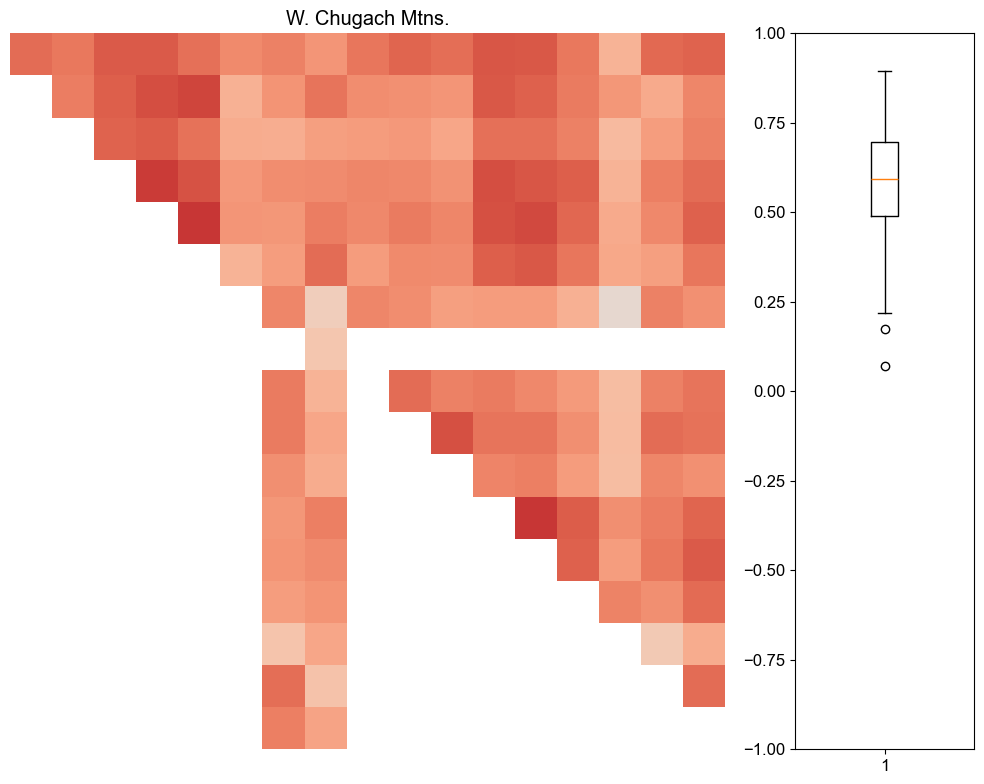

Aleutians


  0%|          | 0/27 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_Aleutians.csv


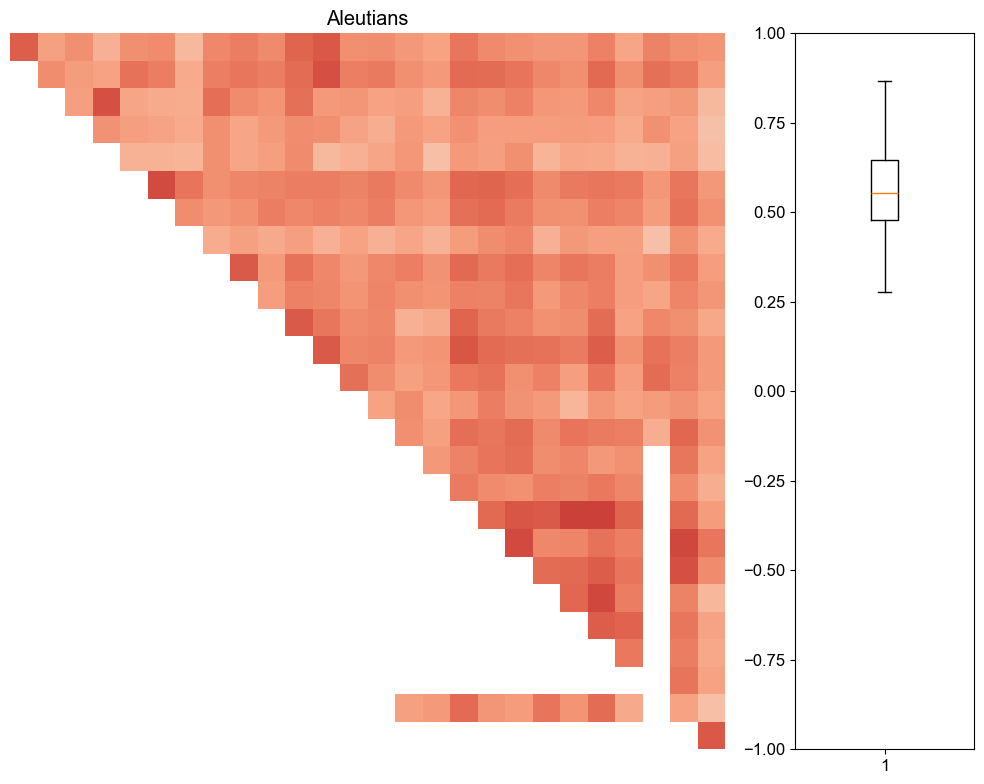

St. Elias Mtns.


  0%|          | 0/25 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_StEliasMtns.csv


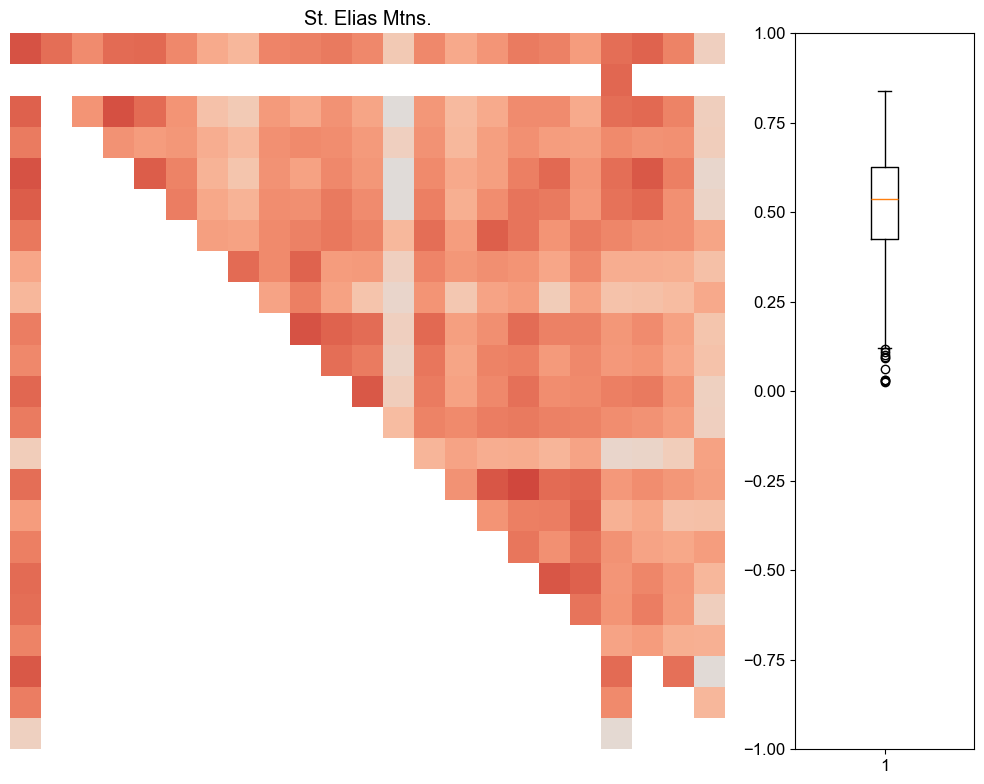

N. Cascades


  0%|          | 0/19 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_NCascades.csv


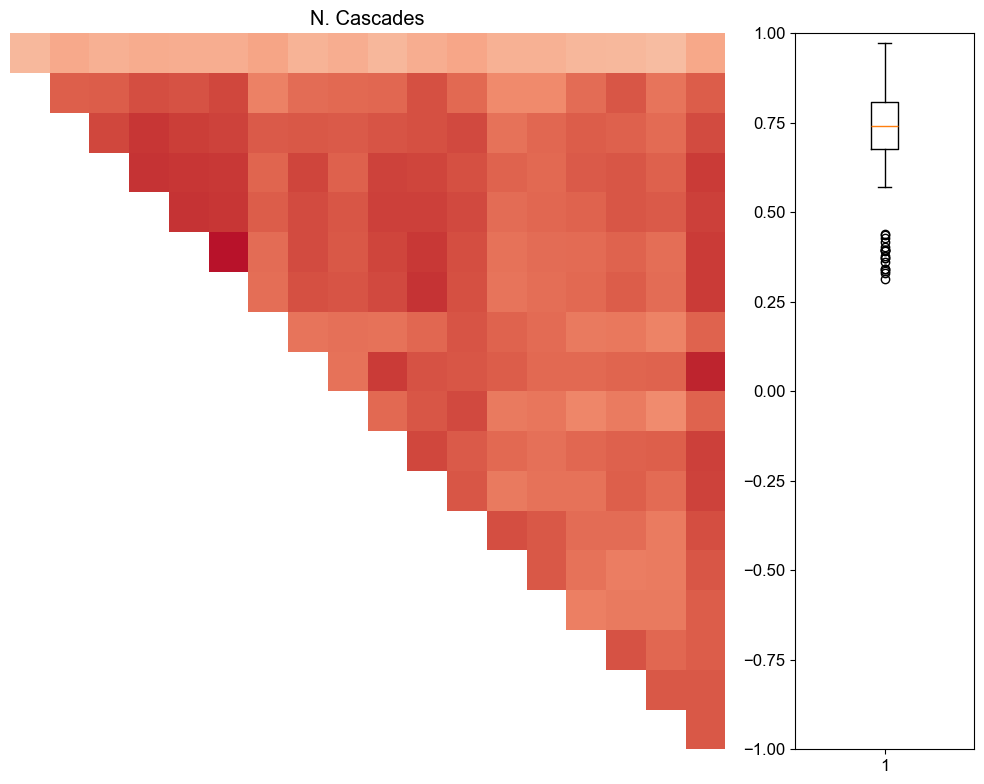

C. Rockies


  0%|          | 0/17 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_CRockies.csv


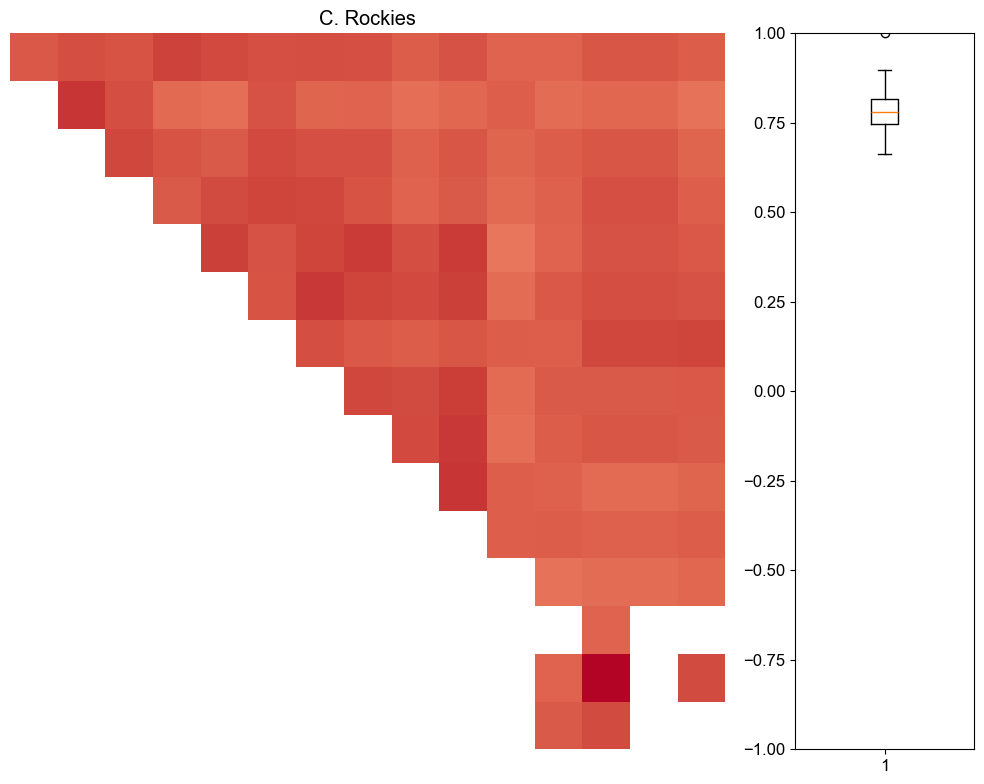

N. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_NRockies.csv


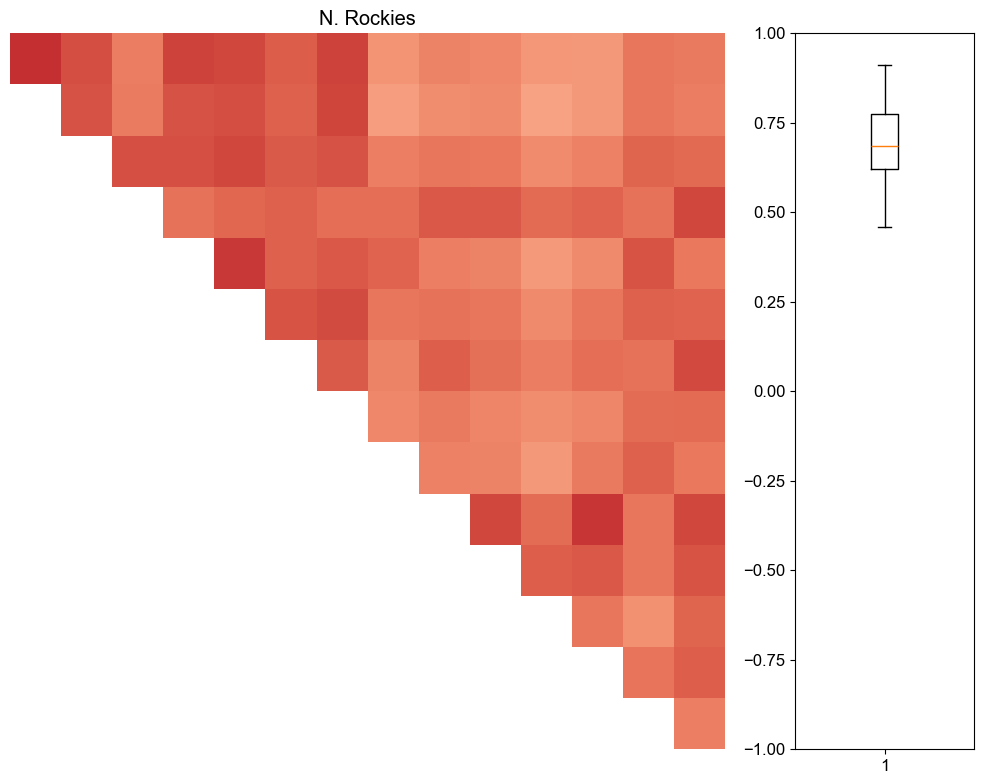

S. Cascades


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_SCascades.csv


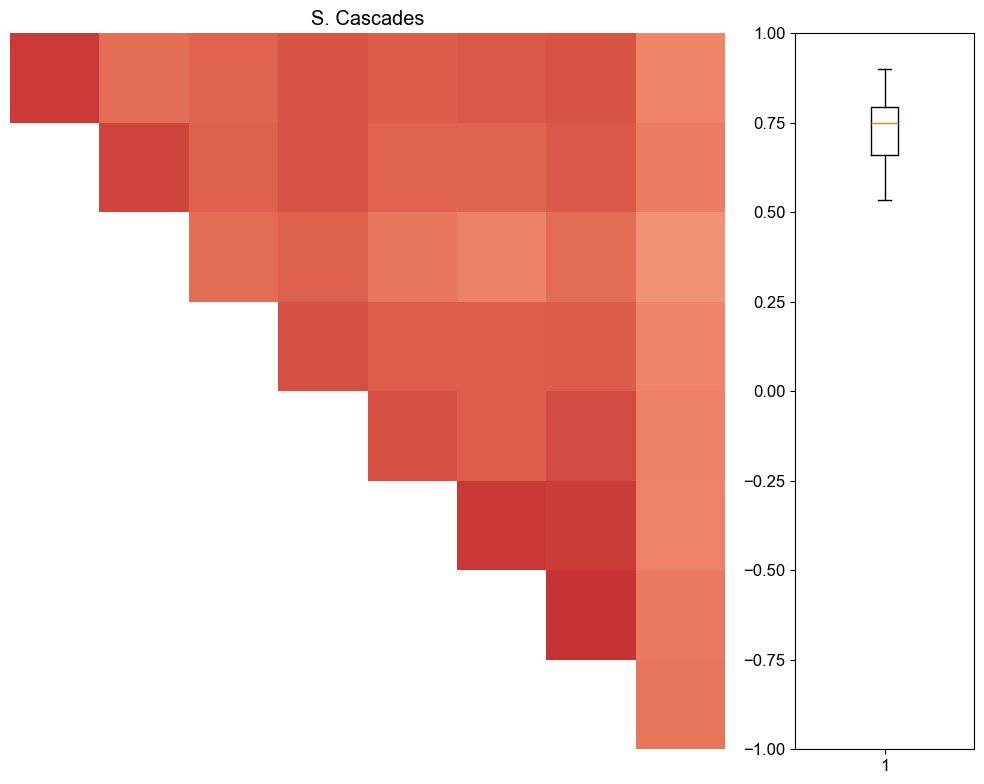

S. Rockies


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_SRockies.csv


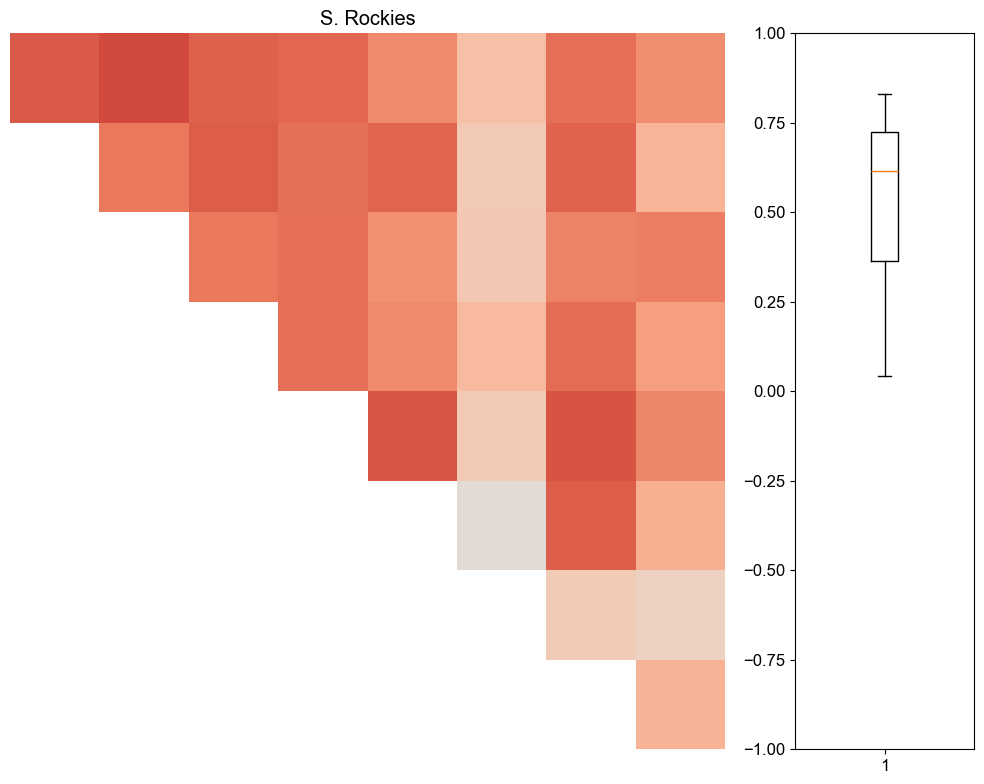

In [5]:
plt.rcParams.update({'font.size':12, 'font.sans-serif': 'Arial'})

# iterate over subregions
for o1region, o2region in aois[['O1Region', 'O2Region']].drop_duplicates().values:
    
    # identify subregion name and color for plotting
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # check if subregion correlations file already exists in file
    correlations_subregion_fn = os.path.join(scm_path, 'results', 
                                             'correlation_coefficients_' 
                                             + subregion_name.replace('.','').replace(' ','') + '.csv')
    if os.path.exists(correlations_subregion_fn):
        print('AAR correlations for subregion already exist in file, skipping...')
        continue

    # initialize dataframe for subregion correlation coefficients
    correlations_subregion = pd.DataFrame()

    # subset AOIs to subregion
    aois_subregion = aois.loc[(aois['O1Region']==o1region) & (aois['O2Region']==o2region)]

    # identify number of sites
    unique_site_names = aois_subregion['RGIId'].drop_duplicates().values

    # iterate over sites in subregion
    for i in tqdm(range(0, len(unique_site_names))):

        # grab site 1 time series
        site1_df = snowlines.loc[snowlines['site_name']==unique_site_names[i]]
        if len(site1_df) < 1:
            continue
        # remove duplicate dates, sort by date
        site1_df = site1_df[~site1_df.index.duplicated(keep='first')].sort_index()  

        # iterate over all other sites in subregion
        for j in range(i+1, len(unique_site_names)):
            
            # grab site 2 time series
            site2_df = snowlines.loc[snowlines['site_name']==unique_site_names[j]]
            if len(site2_df) < 1:
                continue
            # remove duplicate dates, sort by date
            site2_df = site2_df[~site2_df.index.duplicated(keep='first')].sort_index()  

            # resample both dataframes at a daily time interval
            site1_df = site1_df.resample('1D').bfill()
            site2_df = site2_df.resample('1D').bfill()
            min_date = np.min([site1_df.iloc[0]['datetime'], site2_df.iloc[0]['datetime']])
            max_date = np.max([site1_df.iloc[-1]['datetime'], site2_df.iloc[-1]['datetime']])
            site1_df = site1_df.loc[(site1_df['datetime'] >= min_date) & (site1_df['datetime'] <= max_date)]
            site2_df = site2_df.loc[(site2_df['datetime'] >= min_date) & (site2_df['datetime'] <= max_date)]

            # calculate correlation coefficient
            aar_correlation = pd.DataFrame({'Site1': site1_df['AAR'],
                                            'Site2': site2_df['AAR']}).corr().iloc[0,1]
            correlation_sites = pd.DataFrame({'Site1': [unique_site_names[i]],
                                              'Site2': [unique_site_names[j]],
                                              'AAR Corr. Coeff.': [aar_correlation]})
            # append to dataframe
            correlations_subregion = pd.concat([correlations_subregion, correlation_sites])

    # save CSV
    correlations_subregion_pivot = correlations_subregion.pivot_table(index='Site1', 
                                                                      columns='Site2', 
                                                                      values='AAR Corr. Coeff.')
    correlations_subregion_pivot.to_csv(correlations_subregion_fn, index=False)
    print('Correlation coefficients saved to file: ', correlations_subregion_fn)
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [4,1]})
    # heatmap
    sns.heatmap(correlations_subregion_pivot, ax=ax[0], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    ax[0].set_title(subregion_name)
    ax[0].set_xlabel('')
    ax[0].set_xticks([])
    ax[0].set_ylabel('')
    ax[0].set_yticks([])
    # boxplot
    ax[1].boxplot(correlations_subregion['AAR Corr. Coeff.'].values)
    ax[1].set_ylim(-1,1)
    fig.tight_layout()
    plt.show()


## Calculate correlation coefficients between AAR and cumulative PDD time series

In [9]:
# iterate over subregions
for i, (o1region, o2region) in enumerate(aois[['O1Region', 'O2Region']].drop_duplicates().values):
    
    # identify subregion name and color for plotting
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    print(subregion_name)

    # check if subregion AAR-PDD correlations already exist in file
    correlations_subregion_fn = os.path.join(scm_path, 'results',
                                             'correlation_coefficients_aar-pdd_' 
                                             + subregion_name + '.csv')
    if os.path.exists(correlations_subregion_fn):
        print('AAR-PDD correlations already exist in file, skipping...')
        continue
    
    # initialize dataframe for subregion correlation coefficients
    correlations_subregion = pd.DataFrame()

    # subset AOIs to subregion
    aois_subregion = aois.loc[(aois['O1Region']==o1region) & (aois['O2Region']==o2region)]

    # iterate over sites in subregion
    for site_name in tqdm(sorted(aois_subregion['RGIId'].drop_duplicates().values)):

        # grab site snowlines time series
        snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
        if len(snowlines_site) < 1:
            print('No snowlines for', site_name)
            continue
        # remove duplicate dates, sort by date
        snowlines_site = snowlines_site[~snowlines_site.index.duplicated(keep='first')].sort_index()  

        # grab ERA data for site
        era_site = eras.loc[eras['site_name']==site_name]
        if len(era_site) < 1:
            print('No ERA data for', site_name)
            continue
        era_site.index = era_site['Date']
        
        # resample both dataframes at a daily time interval
        snowlines_site = snowlines_site.resample('1D').bfill()
        era_site = era_site.resample('1D').bfill()
        min_date = np.min([snowlines_site.iloc[0]['datetime'], era_site.iloc[0]['Date']])
        max_date = np.max([snowlines_site.iloc[-1]['datetime'], era_site.iloc[-1]['Date']])
        snowlines_site = snowlines_site.loc[(snowlines_site['datetime'] >= min_date) & (snowlines_site['datetime'] <= max_date)]
        era_site = era_site.loc[(era_site['Date'] >= min_date) & (era_site['Date'] <= max_date)]

        # calculate correlation coefficient
        aar_pdd_correlation = pd.DataFrame({'site_name': snowlines_site['AAR'],
                                            'PDD_cumsum': era_site['Cumulative_Positive_Degree_Days']}).corr().iloc[0,1]
        correlation_site = pd.DataFrame({'Site': [site_name],
                                          'AAR-PDD Corr. Coeff.': [aar_pdd_correlation]})
        # append to dataframe
        correlations_subregion = pd.concat([correlations_subregion, correlation_site])

    # save CSV
    correlations_subregion.to_csv(correlations_subregion_fn,index=False)
    print('Correlation coefficients saved to file: ', correlations_subregion_fn)

    # print stats
    print('Correlation coefficients:')
    print('\t Mean:', np.nanmean(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t Std.:', np.nanstd(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t Median:', np.nanmedian(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print('\t IQR:', iqr(correlations_subregion['AAR-PDD Corr. Coeff.']))
    print(' ')
    
plt.show()


Alaska Range
AAR-PDD correlations already exist in file, skipping...
N. Coast Ranges


  0%|          | 0/26 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_N. Coast Ranges.csv
Correlation coefficients:
	 Mean: -0.17772627248823922
	 Std.: 0.06658052517183467
	 Median: -0.18588847741341916
	 IQR: 0.08425923638033042
 
W. Chugach Mtns.


  0%|          | 0/20 [00:00<?, ?it/s]

No snowlines for RGI60-01.09951
No snowlines for RGI60-01.10557
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_W. Chugach Mtns..csv
Correlation coefficients:
	 Mean: -0.21035365842259687
	 Std.: 0.10843282966391818
	 Median: -0.24344561999476289
	 IQR: 0.0708193299059634
 
Aleutians


  0%|          | 0/27 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_Aleutians.csv
Correlation coefficients:
	 Mean: -0.17453508925831318
	 Std.: 0.06750407624867778
	 Median: -0.18288003605406086
	 IQR: 0.07950621409124972
 
St. Elias Mtns.


  0%|          | 0/25 [00:00<?, ?it/s]

No snowlines for RGI60-01.13635
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_St. Elias Mtns..csv
Correlation coefficients:
	 Mean: -0.1304195437991971
	 Std.: 0.11848752142194553
	 Median: -0.13582486169201474
	 IQR: 0.13255272005060473
 
N. Cascades


  0%|          | 0/19 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_N. Cascades.csv
Correlation coefficients:
	 Mean: -0.2561577100699209
	 Std.: 0.04286901387200597
	 Median: -0.2435693437397425
	 IQR: 0.04586892112451596
 
C. Rockies


  0%|          | 0/17 [00:00<?, ?it/s]

No snowlines for RGI60-02.06585
Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_C. Rockies.csv
Correlation coefficients:
	 Mean: -0.21006609449196173
	 Std.: 0.025795999379263596
	 Median: -0.20101794860250144
	 IQR: 0.03983899818521183
 
N. Rockies


  0%|          | 0/15 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_N. Rockies.csv
Correlation coefficients:
	 Mean: -0.10866975851732547
	 Std.: 0.05492731042683062
	 Median: -0.11260772429653618
	 IQR: 0.061377400299222645
 
S. Cascades


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_S. Cascades.csv
Correlation coefficients:
	 Mean: -0.34048541755255535
	 Std.: 0.032725927473227806
	 Median: -0.346376926001424
	 IQR: 0.028037652956248216
 
S. Rockies


  0%|          | 0/9 [00:00<?, ?it/s]

Correlation coefficients saved to file:  /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/results/correlation_coefficients_aar-pdd_S. Rockies.csv
Correlation coefficients:
	 Mean: -0.2688618397988308
	 Std.: 0.07794445433638636
	 Median: -0.2753751426217309
	 IQR: 0.15439698239045377
 
